*Copyright (C) 2021 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# DNF regimes

The following examples demonstrate the fundamental regimes of
DNFs and their associated instabilities that are the basis for all
macroscopic behavior of architectures.


In [1]:
from lava.proc.lif.process import LIF
from lava.lib.dnf.connect.connect import connect
from lava.lib.dnf.operations.operations import Weights
from lava.lib.dnf.operations.operations import Convolution
from lava.lib.dnf.inputs.gauss_pattern.process import GaussPattern
from lava.lib.dnf.inputs.rate_code_spike_gen.process import RateCodeSpikeGen

from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc.monitor.process import Monitor
from lava.proc.monitor.models import PyMonitorModel

from utils import plot_1d, animated_1d_plot


class Architecture:
    """This class structure is not required and is only used here to reduce
    code duplication for different examples."""
    def __init__(self, kernel):
        shape = (15,)
        time_steps = 700

        # Set up spike generator 1
        self.gauss_pattern_1 = GaussPattern(shape=shape,
                                       amplitude=0,
                                       mean=11.25,
                                       stddev=2.25)
        self.spike_generator_1 = RateCodeSpikeGen(shape=shape)
        self.gauss_pattern_1.a_out.connect(self.spike_generator_1.a_in)

        # Set up spike generator 2
        self.gauss_pattern_2 = GaussPattern(shape=shape,
                                       amplitude=0,
                                       mean=3.75,
                                       stddev=2.25)
        self.spike_generator_2 = RateCodeSpikeGen(shape=shape)
        self.gauss_pattern_2.a_out.connect(self.spike_generator_2.a_in)

        # DNF with specified kernel
        self.dnf = LIF(shape=shape, du=409, dv=2047, vth=200)
        connect(self.dnf.s_out, self.dnf.a_in, [Convolution(kernel)])

        # Connect spike input to DNF
        connect(self.spike_generator_1.s_out, self.dnf.a_in, [Weights(25)])
        connect(self.spike_generator_2.s_out, self.dnf.a_in, [Weights(25)])

        # Set up monitors
        self.monitor_dnf = Monitor()
        self.monitor_dnf.probe(target=self.dnf.s_out, num_steps=time_steps)
        self.monitor_input_1 = Monitor()
        self.monitor_input_1.probe(self.spike_generator_1.s_out, time_steps)
        self.monitor_input_2 = Monitor()
        self.monitor_input_2.probe(self.spike_generator_2.s_out, time_steps)

        # Set up a run configuration
        self.run_cfg = Loihi1SimCfg(select_tag="bit_accurate_loihi")

    def run(self):
        # Run the network and make changes to spike inputs over time
        condition = RunSteps(num_steps=100)
        self.gauss_pattern_1.run(condition=condition, run_cfg=self.run_cfg)
        self.gauss_pattern_1.amplitude = 2300
        self.gauss_pattern_2.amplitude = 2300
        self.gauss_pattern_1.run(condition=condition, run_cfg=self.run_cfg)
        self.gauss_pattern_1.amplitude = 11200
        self.gauss_pattern_2.amplitude = 11200
        self.gauss_pattern_1.run(condition=condition, run_cfg=self.run_cfg)
        self.gauss_pattern_1.amplitude = 2300
        self.gauss_pattern_2.amplitude = 2300
        self.gauss_pattern_1.run(condition=RunSteps(num_steps=200),
                                 run_cfg=self.run_cfg)
        self.gauss_pattern_1.amplitude = 0
        self.gauss_pattern_2.amplitude = 0
        self.gauss_pattern_1.run(condition=RunSteps(num_steps=200),
                                 run_cfg=self.run_cfg)

    def plot(self):
        # Get probed data from monitors
        data_dnf = self.monitor_dnf.get_data()\
            [self.dnf.name][self.dnf.s_out.name]
        data_input1 = self.monitor_input_1.get_data()\
            [self.spike_generator_1.name][self.spike_generator_1.s_out.name]
        data_input2 = self.monitor_input_2.get_data()\
            [self.spike_generator_2.name][self.spike_generator_2.s_out.name]

        # Stop the execution of the network
        self.spike_generator_1.stop()

        # Generate a raster plot from the probed data
        plot_1d(data_dnf,
                data_input1,
                data_input2)
        
        # Generate an animated plot from the probed data
        animated_1d_plot(data_dnf,
                         data_input1,
                         data_input2)

## Detection

This example demonstrates the _detection instability_ of DNFs. The DNF receives spike input at two locations, whose spike rate changes over time. Between time step 100 and 200, the spike rate is not high enough for the DNF to form a peak and it does not spike. When the input spike rate is increased after time step 200, the DNF goes through the _detection instability_, forming a peak and producing spike output. When the input spike rate is lowered back to its previous value, the DNF keeps spiking and its peak remains stable. This demonstrates hysteresis of detection - the DNF stabilizes its decision about detecting an input. Only when the input is completely removed at time step 500 does the peak disappear in the _reverse detection instability_.


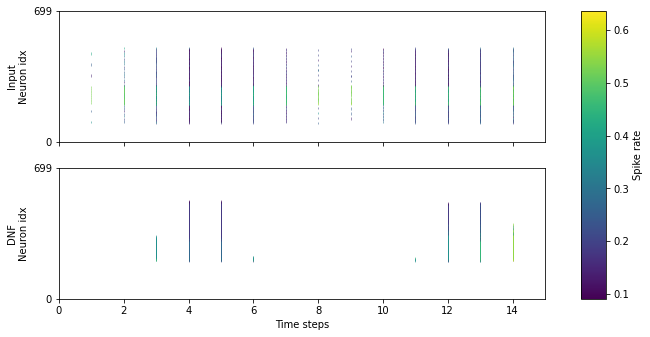

In [2]:
from lava.lib.dnf.kernels.kernels import MultiPeakKernel

detection_kernel = MultiPeakKernel(amp_exc=83, 
                                   width_exc=3.75, 
                                   amp_inh=-70,
                                   width_inh=7.5)

architecture = Architecture(detection_kernel)
architecture.run()
architecture.plot()


## Memory

This example demonstrates the memory property of DNFs. The input and connectivity is structured like in the example on 'detection' above but here the local excitation is stronger. This leads to the two peaks in the DNF to remain stable even after the input is deactivated in time step 400. The DNF has thus formed a memory of the inputs being present at those locations. Even though such self-sustained peaks are stable without input, they may track present input that changes its location in a graded manner.

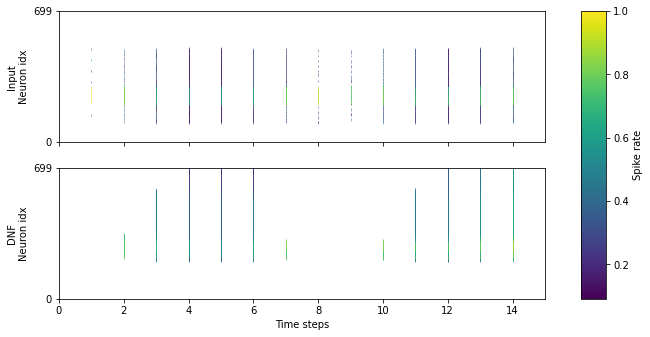

In [3]:
memory_kernel = MultiPeakKernel(amp_exc=32, 
                                width_exc=2.5, 
                                amp_inh=-18, 
                                width_inh=4.5)

architecture = Architecture(memory_kernel)
architecture.run()
architecture.plot()

## Selection

This example demonstrates the _selection instability_ of a DNF. With spike input at two locations, the DNF makes a selection decision at time step 100, creating a peak at only one of the input locations. That decision remains stable even though two inputs are present simultaneously for the subsequent 100 time steps. The selection switches only when the first input is deactivates at time step 200. It then remains stable on the second input location even as the first input is activated again at time step 300. This demonstrates hysteresis of selection - the DNF stabilizes its selection decision. The same behavior is demonstrated again between time step 400 and 600 for the first input.

Note: The selection is biased/forced here to always be on the input centered on neuron 11 to fit the structure of the input. To achieve this, this input is activated one time step before the other input. If both were activated at the same time step the selection decision would be random. The DNF may then select the "wrong" input and the example would not work.

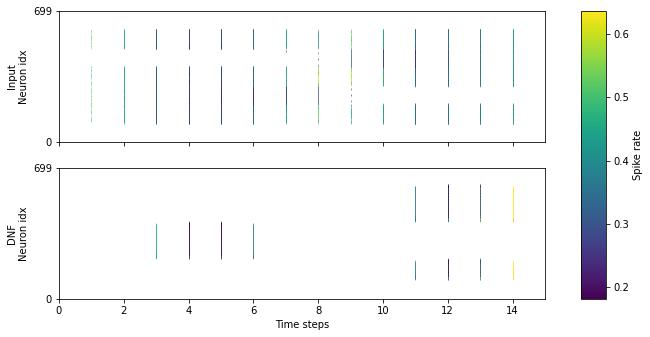

In [4]:
from lava.lib.dnf.kernels.kernels import SelectiveKernel

class SelectiveArchitecture(Architecture):
    """Class that overrides the run function to specify a different input
    structure."""
    def run(self):
        # Run the network and make changes to spike inputs over time
        self.dnf.run(condition=RunSteps(num_steps=99), run_cfg=self.run_cfg)
        self.gauss_pattern_1.amplitude = 10000
        self.dnf.run(condition=RunSteps(num_steps=1), run_cfg=self.run_cfg)
        self.gauss_pattern_2.amplitude = 10000
        self.dnf.run(condition=RunSteps(num_steps=100), run_cfg=self.run_cfg)
        self.gauss_pattern_1.amplitude = 0
        self.dnf.run(condition=RunSteps(num_steps=100), run_cfg=self.run_cfg)
        self.gauss_pattern_1.amplitude = 10000
        self.dnf.run(condition=RunSteps(num_steps=100), run_cfg=self.run_cfg)
        self.gauss_pattern_2.amplitude = 0
        self.dnf.run(condition=RunSteps(num_steps=100), run_cfg=self.run_cfg)
        self.gauss_pattern_2.amplitude = 10000
        self.dnf.run(condition=RunSteps(num_steps=100), run_cfg=self.run_cfg)
        self.gauss_pattern_1.amplitude = 0
        self.gauss_pattern_2.amplitude = 0
        self.dnf.run(condition=RunSteps(num_steps=100), run_cfg=self.run_cfg)


selection_kernel = SelectiveKernel(amp_exc=20, 
                                   width_exc=2.25, 
                                   global_inh=-15)

architecture = SelectiveArchitecture(selection_kernel)
architecture.run()
architecture.plot()